# Temperature and humidity dataset

This dataset was created using a raspberry pi connected to a DHT11 temperature and humidity sensor which was set up to log the room temperature every 15 minutes over a set period and print the results to a CSV file. The CSV file was used to create an SQL database. [Click here](https://github.com/blaze21777/RaspberryPi-Projects/tree/master/DHT11_Humidity_Sensor) for the Raspberry pi project and CSV. [Click here](https://github.com/blaze21777/SQL-Projects/tree/master/Temperature_Humidity_Dataset) for the SQL project. 

The docker compose file sets up PG admin and a postgres database to access the data.
- In the folder with the docker file run ```docker compose up```



### The Dataset

* id SERIAL,            
* date TIMESTAMP ,
* year SMALLINT ,
* month SMALLINT ,
* day SMALLINT ,
* time TIME ,
* temperature NUMERIC, (degrees celsius)
* humidity NUMERIC,    (percentage %)
* PRIMARY KEY (id)

The full date was split to make it easier to work with the individual parts if required. 

### Project Objective
The goal of the project was to discover if there is any meaningful relationship between temperature, humidity and time within the room. 

### Key Background information
* Humidity indicates the likelihood for precipitation, dew, or fog to be present.
* Humidity depends on the temperature and pressure of the system of interest.
    - The same amount of water vapor results in higher relative humidity in cool air than warm air.
    - The amount of water vapor needed to achieve saturation increases as the temperature increases.
* **Relative humidity was measured**
    - Relative humidity, often expressed as a percentage, indicates a present state of absolute humidity relative to a maximum humidity given the same temperature.
* [Source](https://en.wikipedia.org/wiki/Humidity)

In [1]:
# Import packages 
import os
import pandas as pd
import numpy as np
import psycopg2
import sqlalchemy
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import metrics
%matplotlib inline
# Import Meteostat library and dependencies
from datetime import datetime
from meteostat import Point, Hourly

# Load database

In [2]:
def get_engine(user, passwd, host, port, db):
    url = f"postgresql://{user}:{passwd}@{host}:{port}/{db}"
    engine = create_engine(url, pool_size=50, echo=False)
    return engine

In [3]:
engine = get_engine("docker", "docker","localhost",5432,"postgres")
print(sqlalchemy.__version__)

1.4.41


In [4]:
# Run SQL query and store in dataframe
df_temperature_data = pd.read_sql(
    # Humidity cannot exceed 100%
    "SELECT * FROM temp_data WHERE humidity <= 100",
    engine,
)
df_temperature_data.head()

,id,date,year,month,day,time,temperature,humidity
0,1,2022-07-18 16:48:32.839391,2022,7,18,16:48:32,33.0,25.0
1,2,2022-07-18 17:03:33.364782,2022,7,18,17:03:33,34.0,28.0
2,3,2022-07-18 17:18:33.890008,2022,7,18,17:18:33,34.0,27.0
3,5,2022-07-18 17:48:34.940317,2022,7,18,17:48:34,34.0,28.0
4,6,2022-07-18 18:03:35.465421,2022,7,18,18:03:35,34.0,27.0


In [5]:
# id column will not provide any useful information
df_temperature_data.drop("id", axis=1, inplace=True)
df_temperature_data.head()

,date,year,month,day,time,temperature,humidity
0,2022-07-18 16:48:32.839391,2022,7,18,16:48:32,33.0,25.0
1,2022-07-18 17:03:33.364782,2022,7,18,17:03:33,34.0,28.0
2,2022-07-18 17:18:33.890008,2022,7,18,17:18:33,34.0,27.0
3,2022-07-18 17:48:34.940317,2022,7,18,17:48:34,34.0,28.0
4,2022-07-18 18:03:35.465421,2022,7,18,18:03:35,34.0,27.0


In [6]:
df_temperature_data.tail()

,date,year,month,day,time,temperature,humidity
5800,2022-09-25 06:30:47.503439,2022,9,25,06:30:47,20.0,55.0
5801,2022-09-25 06:45:48.028706,2022,9,25,06:45:48,20.0,55.0
5802,2022-09-25 07:00:48.553815,2022,9,25,07:00:48,20.0,54.0
5803,2022-09-25 07:15:49.079062,2022,9,25,07:15:49,20.0,54.0
5804,2022-09-25 07:30:49.604484,2022,9,25,07:30:49,20.0,54.0


# Get data from api

<table>
    <thead>
        <tr>
            <th style="text-align: left;"><strong>Column</strong></th>
            <th style="text-align: left;"><strong>Description</strong></th>
            <th style="text-align: left;"><strong>Type</strong></th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align: left;">station</td>
            <td style="text-align: left;">The Meteostat ID of the weather station (only if query refers to multiple
                stations)</td>
            <td style="text-align: left;">String</td>
        </tr>
        <tr>
            <td style="text-align: left;">time</td>
            <td style="text-align: left;">The datetime of the observation</td>
            <td style="text-align: left;">Datetime64</td>
        </tr>
        <tr>
            <td style="text-align: left;">temp</td>
            <td style="text-align: left;">The air temperature in <em>°C</em></td>
            <td style="text-align: left;">Float64</td>
        </tr>
        <tr>
            <td style="text-align: left;">dwpt</td>
            <td style="text-align: left;">The dew point in <em>°C</em></td>
            <td style="text-align: left;">Float64</td>
        </tr>
        <tr>
            <td style="text-align: left;">rhum</td>
            <td style="text-align: left;">The relative humidity in percent (<em>%</em>)</td>
            <td style="text-align: left;">Float64</td>
        </tr>
        <tr>
            <td style="text-align: left;">prcp</td>
            <td style="text-align: left;">The one hour precipitation total in <em>mm</em></td>
            <td style="text-align: left;">Float64</td>
        </tr>
        <tr>
            <td style="text-align: left;">snow</td>
            <td style="text-align: left;">The snow depth in <em>mm</em></td>
            <td style="text-align: left;">Float64</td>
        </tr>
        <tr>
            <td style="text-align: left;">wdir</td>
            <td style="text-align: left;">The average wind direction in degrees (<em>°</em>)</td>
            <td style="text-align: left;">Float64</td>
        </tr>
        <tr>
            <td style="text-align: left;">wspd</td>
            <td style="text-align: left;">The average wind speed in <em>km/h</em></td>
            <td style="text-align: left;">Float64</td>
        </tr>
        <tr>
            <td style="text-align: left;">wpgt</td>
            <td style="text-align: left;">The peak wind gust in <em>km/h</em></td>
            <td style="text-align: left;">Float64</td>
        </tr>
        <tr>
            <td style="text-align: left;">pres</td>
            <td style="text-align: left;">The average sea-level air pressure in <em>hPa</em></td>
            <td style="text-align: left;">Float64</td>
        </tr>
        <tr>
            <td style="text-align: left;">tsun</td>
            <td style="text-align: left;">The one hour sunshine total in minutes (<em>m</em>)</td>
            <td style="text-align: left;">Float64</td>
        </tr>
    </tbody>
</table>

In [7]:
LAT = 51.4183
LONG = 0.2206

# Set time period
start = df_temperature_data.iloc[0].date.to_pydatetime()
end = df_temperature_data.iloc[-1].date.to_pydatetime()

# Create Point for Vancouver, BC
location = Point(LAT, LONG)

# Get daily data for data in datadrame
data = Hourly(location, start, end)
data = data.fetch()

In [8]:
data.head()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2022-07-18 17:00:00,35.0,8.7,20.0,0.0,NaN,210.0,14.8,25.9,1017.0,NaN,1.0
2022-07-18 18:00:00,34.0,7.9,20.0,0.0,NaN,160.0,13.0,24.1,1017.0,NaN,1.0
2022-07-18 19:00:00,33.0,7.1,20.0,0.0,NaN,170.0,11.2,22.2,1017.0,NaN,1.0
2022-07-18 20:00:00,31.0,8.1,24.0,0.0,NaN,160.0,7.6,18.5,1017.0,NaN,1.0
2022-07-18 21:00:00,29.0,12.8,37.0,0.0,NaN,80.0,7.6,16.7,1017.0,NaN,1.0


In [9]:
df_temperature_data.iloc[0].date.to_pydatetime()

datetime.datetime(2022, 7, 18, 16, 48, 32, 839391)

In [10]:
data.head()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2022-07-18 17:00:00,35.0,8.7,20.0,0.0,NaN,210.0,14.8,25.9,1017.0,NaN,1.0
2022-07-18 18:00:00,34.0,7.9,20.0,0.0,NaN,160.0,13.0,24.1,1017.0,NaN,1.0
2022-07-18 19:00:00,33.0,7.1,20.0,0.0,NaN,170.0,11.2,22.2,1017.0,NaN,1.0
2022-07-18 20:00:00,31.0,8.1,24.0,0.0,NaN,160.0,7.6,18.5,1017.0,NaN,1.0
2022-07-18 21:00:00,29.0,12.8,37.0,0.0,NaN,80.0,7.6,16.7,1017.0,NaN,1.0


# Combine data

In [11]:
df_temperature_data.head()

,date,year,month,day,time,temperature,humidity
0,2022-07-18 16:48:32.839391,2022,7,18,16:48:32,33.0,25.0
1,2022-07-18 17:03:33.364782,2022,7,18,17:03:33,34.0,28.0
2,2022-07-18 17:18:33.890008,2022,7,18,17:18:33,34.0,27.0
3,2022-07-18 17:48:34.940317,2022,7,18,17:48:34,34.0,28.0
4,2022-07-18 18:03:35.465421,2022,7,18,18:03:35,34.0,27.0


In [12]:
# Create colum of rounded dates 
df_temperature_data["date_rounded"] = df_temperature_data["date"].apply(
    lambda x: x.round(freq="H")
)

In [13]:
# Move position of date_rounded 
df_temp = df_temperature_data["date_rounded"]
df_temperature_data.drop(["date_rounded"], inplace=True, axis=1)
df_temperature_data.insert(1, "date_rounded", df_temp)
df_temperature_data.head()

,date,date_rounded,year,month,day,time,temperature,humidity
0,2022-07-18 16:48:32.839391,2022-07-18 17:00:00,2022,7,18,16:48:32,33.0,25.0
1,2022-07-18 17:03:33.364782,2022-07-18 17:00:00,2022,7,18,17:03:33,34.0,28.0
2,2022-07-18 17:18:33.890008,2022-07-18 17:00:00,2022,7,18,17:18:33,34.0,27.0
3,2022-07-18 17:48:34.940317,2022-07-18 18:00:00,2022,7,18,17:48:34,34.0,28.0
4,2022-07-18 18:03:35.465421,2022-07-18 18:00:00,2022,7,18,18:03:35,34.0,27.0


In [14]:
df_combined_data = df_temperature_data.merge(
    data, left_on="date_rounded", right_on="time", how="left"
)
df_combined_data.head()

,date,date_rounded,year,month,day,time,temperature,humidity,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
0,2022-07-18 16:48:32.839391,2022-07-18 17:00:00,2022,7,18,16:48:32,33.0,25.0,35.0,8.7,20.0,0.0,NaN,210.0,14.8,25.9,1017.0,NaN,1.0
1,2022-07-18 17:03:33.364782,2022-07-18 17:00:00,2022,7,18,17:03:33,34.0,28.0,35.0,8.7,20.0,0.0,NaN,210.0,14.8,25.9,1017.0,NaN,1.0
2,2022-07-18 17:18:33.890008,2022-07-18 17:00:00,2022,7,18,17:18:33,34.0,27.0,35.0,8.7,20.0,0.0,NaN,210.0,14.8,25.9,1017.0,NaN,1.0
3,2022-07-18 17:48:34.940317,2022-07-18 18:00:00,2022,7,18,17:48:34,34.0,28.0,34.0,7.9,20.0,0.0,NaN,160.0,13.0,24.1,1017.0,NaN,1.0
4,2022-07-18 18:03:35.465421,2022-07-18 18:00:00,2022,7,18,18:03:35,34.0,27.0,34.0,7.9,20.0,0.0,NaN,160.0,13.0,24.1,1017.0,NaN,1.0


In [15]:
df_combined_data.rename(
    columns={
        "temperature": "room_temp",
        "temp": "outside_temp",
        "humidity": "room_rhum",
        "rhum": "outside_rhum",
    }, inplace=True
)

# Exploratory Data Analysis

In [16]:
# Displays the names of columns, the data types they contain,
# and whether they have any missing values.
df_combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5805 entries, 0 to 5804
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          5805 non-null   datetime64[ns]
 1   date_rounded  5805 non-null   datetime64[ns]
 2   year          5805 non-null   int64         
 3   month         5805 non-null   int64         
 4   day           5805 non-null   int64         
 5   time          5805 non-null   object        
 6   room_temp     5805 non-null   float64       
 7   room_rhum     5805 non-null   float64       
 8   outside_temp  5804 non-null   float64       
 9   dwpt          5804 non-null   float64       
 10  outside_rhum  5804 non-null   float64       
 11  prcp          5804 non-null   float64       
 12  snow          0 non-null      float64       
 13  wdir          5804 non-null   float64       
 14  wspd          5804 non-null   float64       
 15  wpgt          5804 non-null   float64 

In [17]:
# Another way to check null values
df_combined_data.isnull().sum()

date               0
date_rounded       0
year               0
month              0
day                0
time               0
room_temp          0
room_rhum          0
outside_temp       1
dwpt               1
outside_rhum       1
prcp               1
snow            5805
wdir               1
wspd               1
wpgt               1
pres               1
tsun            5805
coco               1
dtype: int64

In [18]:
# These are all NaN drop columns 
df_combined_data.drop(["snow", "tsun"], inplace=True, axis=1)

In [19]:
# remove null vaules
df_combined_data = df_combined_data[
    [
        "date",
        "date_rounded",
        "year",
        "month",
        "day",
        "time",
        "room_temp",
        "room_rhum",
        "outside_temp",
        "dwpt",
        "outside_rhum",
        "prcp",
        "wdir",
        "wspd",
        "wpgt",
        "pres",
        "coco",
    ]
].dropna()

In [20]:
df_combined_data.head()

,date,date_rounded,year,month,day,time,room_temp,room_rhum,outside_temp,dwpt,outside_rhum,prcp,wdir,wspd,wpgt,pres,coco
0,2022-07-18 16:48:32.839391,2022-07-18 17:00:00,2022,7,18,16:48:32,33.0,25.0,35.0,8.7,20.0,0.0,210.0,14.8,25.9,1017.0,1.0
1,2022-07-18 17:03:33.364782,2022-07-18 17:00:00,2022,7,18,17:03:33,34.0,28.0,35.0,8.7,20.0,0.0,210.0,14.8,25.9,1017.0,1.0
2,2022-07-18 17:18:33.890008,2022-07-18 17:00:00,2022,7,18,17:18:33,34.0,27.0,35.0,8.7,20.0,0.0,210.0,14.8,25.9,1017.0,1.0
3,2022-07-18 17:48:34.940317,2022-07-18 18:00:00,2022,7,18,17:48:34,34.0,28.0,34.0,7.9,20.0,0.0,160.0,13.0,24.1,1017.0,1.0
4,2022-07-18 18:03:35.465421,2022-07-18 18:00:00,2022,7,18,18:03:35,34.0,27.0,34.0,7.9,20.0,0.0,160.0,13.0,24.1,1017.0,1.0


In [21]:
df_combined_data.isnull().sum()

date            0
date_rounded    0
year            0
month           0
day             0
time            0
room_temp       0
room_rhum       0
outside_temp    0
dwpt            0
outside_rhum    0
prcp            0
wdir            0
wspd            0
wpgt            0
pres            0
coco            0
dtype: int64

In [22]:
# Get shape of data 
df_combined_data.shape

(5804, 17)

In [23]:
# Get the number of unique values in each of the columns 
df_combined_data.nunique()

date            5804
date_rounded    1461
year               1
month              3
day               31
time            5778
room_temp         17
room_rhum         52
outside_temp      31
dwpt              66
outside_rhum      66
prcp              21
wdir              67
wspd              21
wpgt              67
pres              42
coco               9
dtype: int64

## Measures of Central Tendency and Dispersion 
- If median and mean are similar it shows that there are few outliers in the data.

In [24]:
# Get mean of temperature
temp_mean = df_combined_data["room_temp"].mean()
temp_mean

26.46106133700896

In [25]:
# Get median of temperature
temp_med = df_combined_data["room_temp"].median()
temp_med

27.0

In [26]:
# Get the mode of temperature
temp_mode = df_combined_data["room_temp"].mode()
temp_mode

0    27.0
Name: room_temp, dtype: float64

In [27]:
# Get percentage of temperature values
df_combined_data["room_temp"].value_counts(normalize=True).sort_values(
    ascending=False
) * 100

27.0    16.040662
28.0    14.266023
26.0    12.129566
25.0    11.767746
29.0     9.011027
22.0     8.442453
24.0     6.616127
23.0     5.099931
30.0     4.583046
31.0     3.756030
21.0     3.118539
32.0     2.705031
34.0     0.740868
33.0     0.671950
20.0     0.620262
35.0     0.396278
36.0     0.034459
Name: room_temp, dtype: float64

In [28]:
# Get mean of humidity
humid_mean = df_combined_data["room_rhum"].mean()

In [29]:
# Get median of humidity
humid_med = df_combined_data["room_rhum"].median()

In [30]:
# Get the mode of humidity
humid_mode = df_combined_data["room_rhum"].mode()

In [31]:
# Get percentage of humidity values
df_combined_data["room_rhum"].value_counts(normalize=True).sort_values(
    ascending=False
) * 100

48.0    4.341833
52.0    4.152309
54.0    4.014473
49.0    4.014473
56.0    3.980014
53.0    3.980014
41.0    3.928325
47.0    3.773260
57.0    3.756030
50.0    3.756030
60.0    3.721571
42.0    3.583735
46.0    3.566506
55.0    3.411440
59.0    3.290834
58.0    3.273604
61.0    3.101309
51.0    2.860096
43.0    2.842867
44.0    2.601654
45.0    2.584425
40.0    2.481048
62.0    2.325982
64.0    1.757409
63.0    1.567884
35.0    1.481737
39.0    1.361130
65.0    1.326671
34.0    1.326671
67.0    1.326671
38.0    1.309442
37.0    1.292212
66.0    1.206065
68.0    1.068229
36.0    1.016540
32.0    0.758098
33.0    0.740868
69.0    0.671950
70.0    0.499655
31.0    0.447967
71.0    0.379049
72.0    0.327360
29.0    0.206754
30.0    0.172295
28.0    0.103377
27.0    0.103377
25.0    0.086147
26.0    0.034459
73.0    0.034459
22.0    0.017229
23.0    0.017229
24.0    0.017229
Name: room_rhum, dtype: float64

The minimum temperature is 12 which is a very unlikely number due to the average temperatures and a humidity over 100 is impossible since it is a percentage.

In [32]:
# Returns some summary stats such as count,
# mean, std, min, max and data types
display(df_combined_data[["room_rhum", "room_temp"]].describe())
# df_combined_data.describe(include=object)

,room_rhum,room_temp
count,5804.000000,5804.000000
mean,50.938318,26.461061
std,9.156215,2.886329
min,22.000000,20.000000
25%,44.000000,25.000000
50%,51.000000,27.000000
75%,58.000000,28.000000
max,73.000000,36.000000


Text(0.5, 1.0, 'Temperature Data')

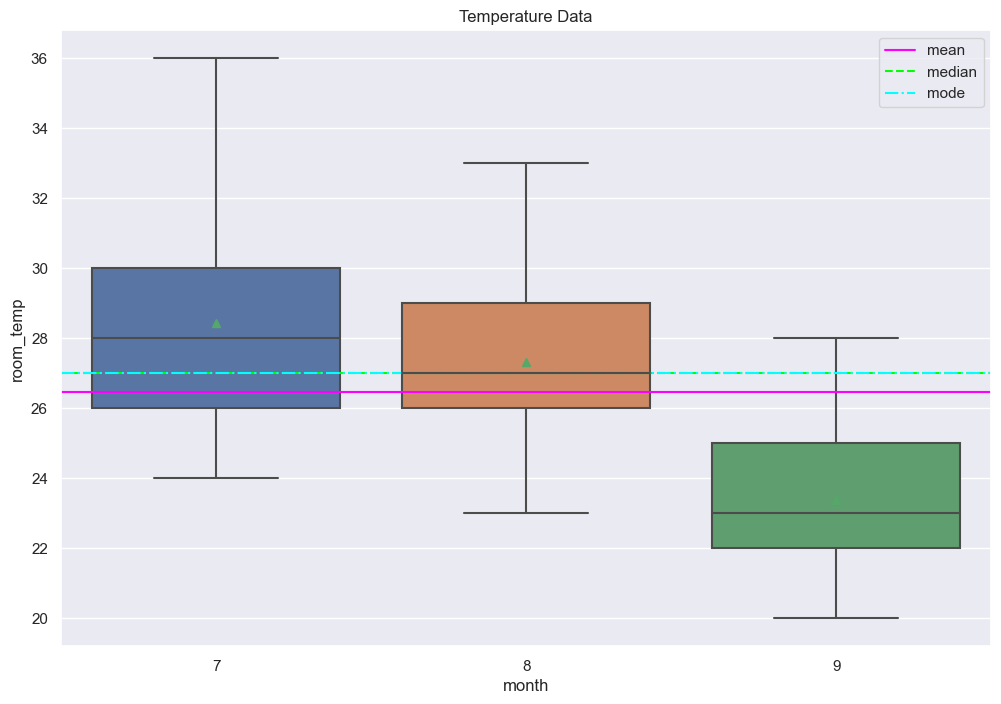

In [33]:
# Plot box plots for temperature over the months
plt.figure(figsize=(12, 8))

sns.boxplot(data=df_combined_data, x="month", y="room_temp", showmeans=True)

plt.axhline(y=temp_mean, color="magenta", linestyle="solid", label="mean")
plt.axhline(y=temp_med, color="lime", linestyle="dashed", label="median")
plt.axhline(y=int(temp_mode), color="cyan", linestyle="dashdot", label="mode")

plt.legend()
plt.title("Temperature Data")

Text(0.5, 1.0, 'Humidity Data')

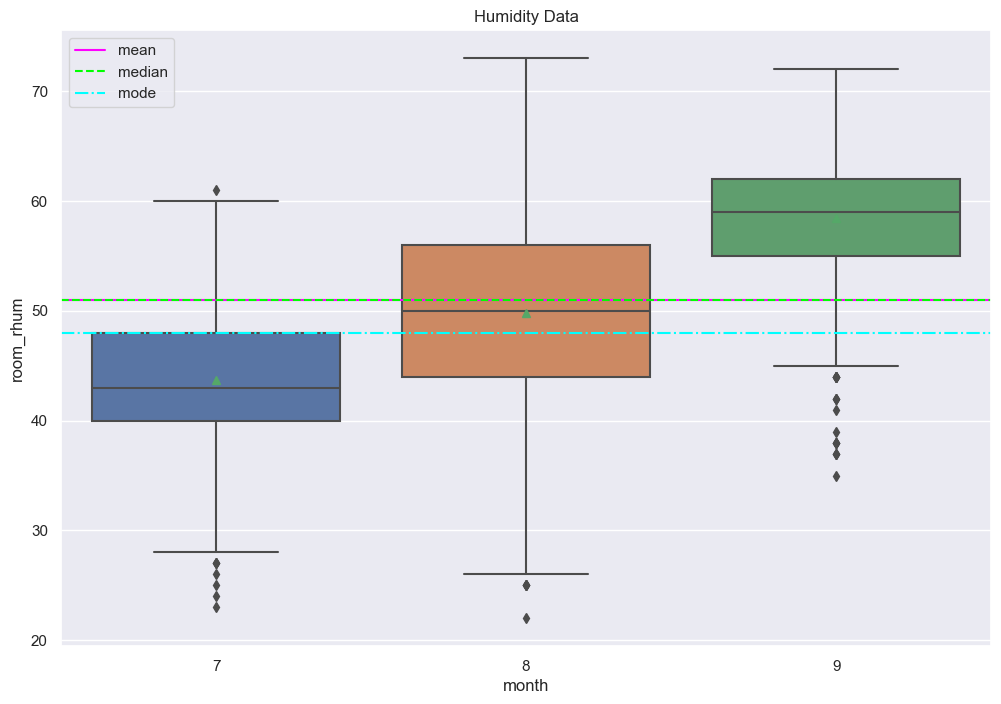

In [34]:
# Plot box plots for humidity over the months
plt.figure(figsize=(12, 8))

sns.boxplot(data=df_combined_data, x="month", y="room_rhum", showmeans=True)

plt.axhline(y=humid_mean, color="magenta", linestyle="solid", label="mean")
plt.axhline(y=humid_med, color="lime", linestyle="dashed", label="median")
plt.axhline(y=int(humid_mode), color="cyan", linestyle="dashdot", label="mode")

plt.legend()
plt.title("Humidity Data")

## Measures of Dispersion 

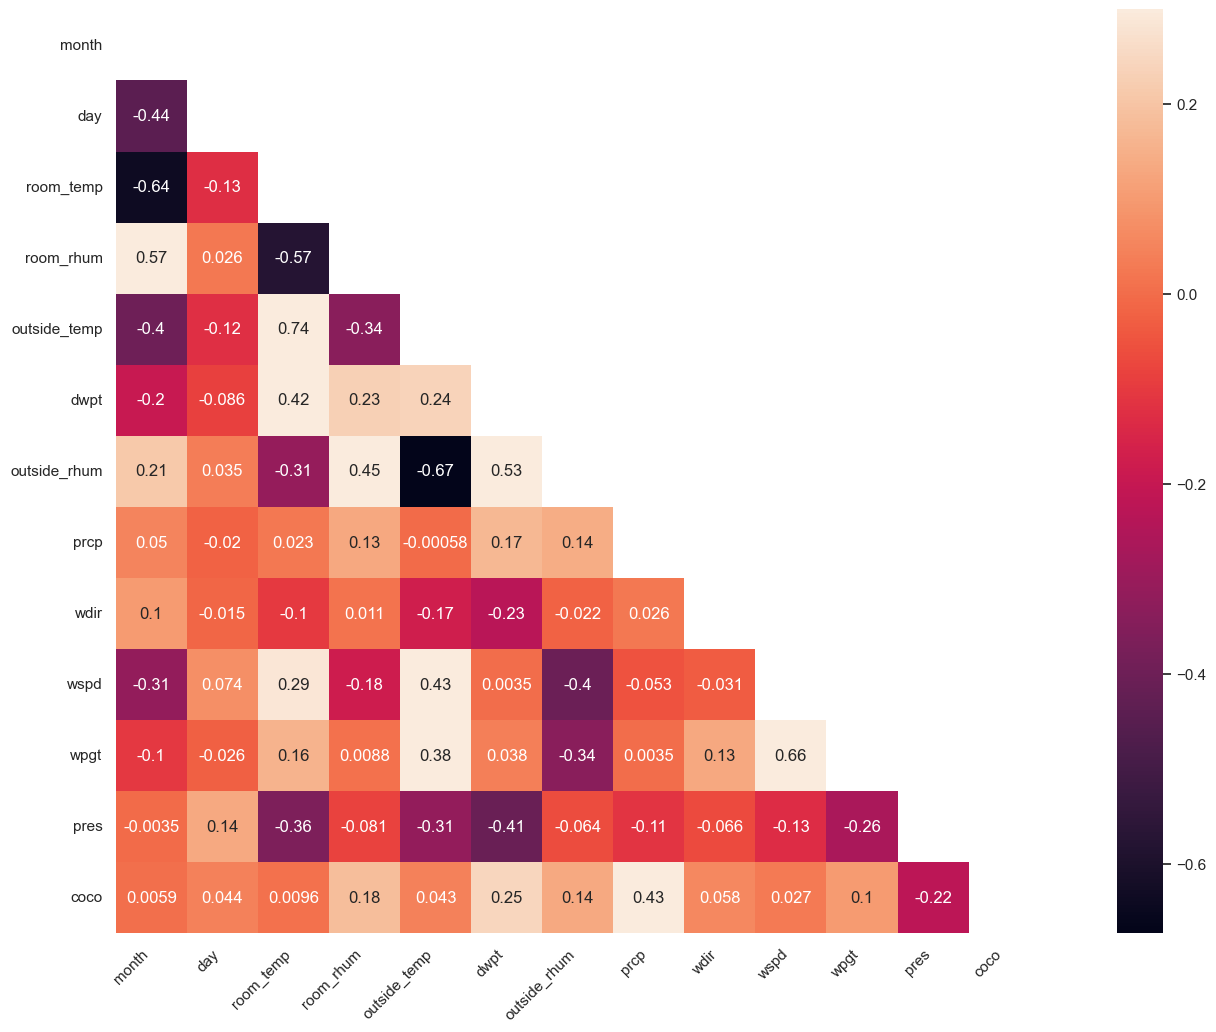

In [35]:
# year shows only nan
corr = df_combined_data.drop(["year"], axis=1).corr(numeric_only=True)

# Plot half of matrix
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 12))
    ax = sns.heatmap(corr, mask=mask, annot=True, vmax=0.3, square=True)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0, ha='right')

Text(0.5, 1.0, 'Room Temperature vs Room Humidity')

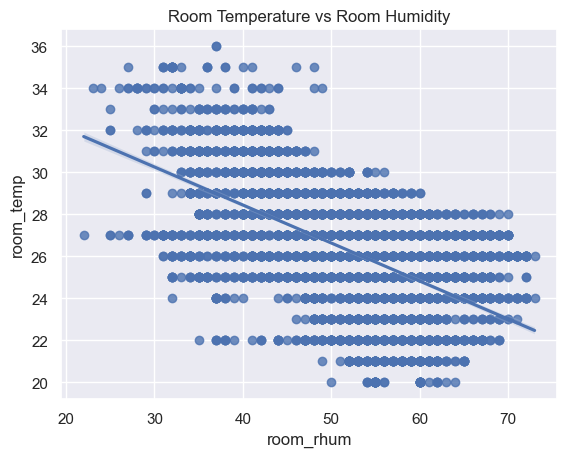

In [36]:
# use the function regplot to make a scatterplot
sns.regplot(data=df_combined_data, x="room_rhum", y="room_temp");
plt.title("Room Temperature vs Room Humidity")

Text(0.5, 1.0, 'Outside Temperature vs Outside Humidity')

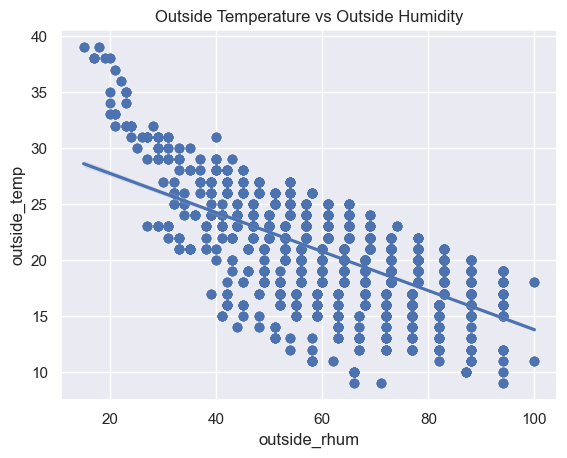

In [37]:
sns.regplot(data=df_combined_data, x="outside_rhum", y="outside_temp");
plt.title("Outside Temperature vs Outside Humidity")

In [38]:
#sns.pairplot(data=df_combined_data, diag_kind="hist", corner=True);

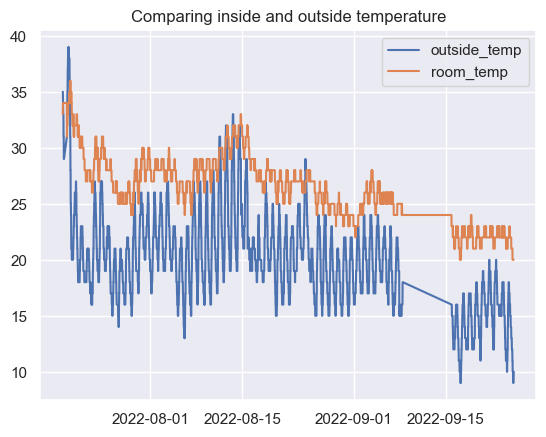

In [39]:
plt.plot(df_combined_data["date"], df_combined_data["outside_temp"], label = "outside_temp")
plt.plot(df_combined_data["date"], df_combined_data["room_temp"], label = "room_temp")
plt.title("Comparing inside and outside temperature")
plt.legend();

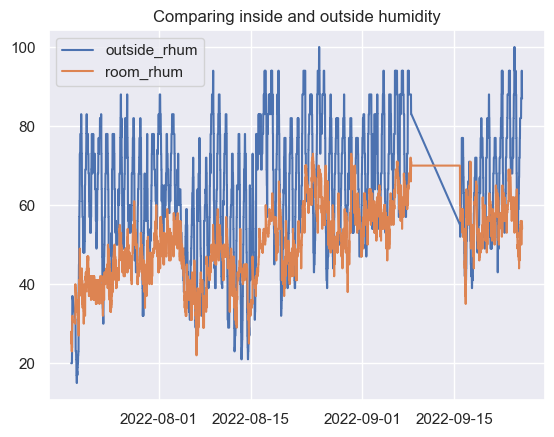

In [40]:
plt.plot(df_combined_data["date"], df_combined_data["outside_rhum"], label = "outside_rhum")
plt.plot(df_combined_data["date"], df_combined_data["room_rhum"], label = "room_rhum")
plt.title("Comparing inside and outside humidity")
plt.legend();

# Building the model 

In [41]:
df_combined_data.columns

Index(['date', 'date_rounded', 'year', 'month', 'day', 'time', 'room_temp',
       'room_rhum', 'outside_temp', 'dwpt', 'outside_rhum', 'prcp', 'wdir',
       'wspd', 'wpgt', 'pres', 'coco'],
      dtype='object')

In [42]:
X = df_combined_data[["month", "room_rhum","outside_temp","outside_rhum"]].values
y = df_combined_data["room_temp"]

In [43]:
# Split up df into training and test groups
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1 / 3, random_state=42
)

In [44]:
mlr = LinearRegression()
mlr.fit(X_train, y_train)

LinearRegression()

In [45]:
mlr.intercept_

20.965321055964456

In [46]:
mlr.coef_

array([-0.6333227 , -0.13215482,  0.58680385,  0.08692741])

In [47]:
y_pred = mlr.predict(X_test)

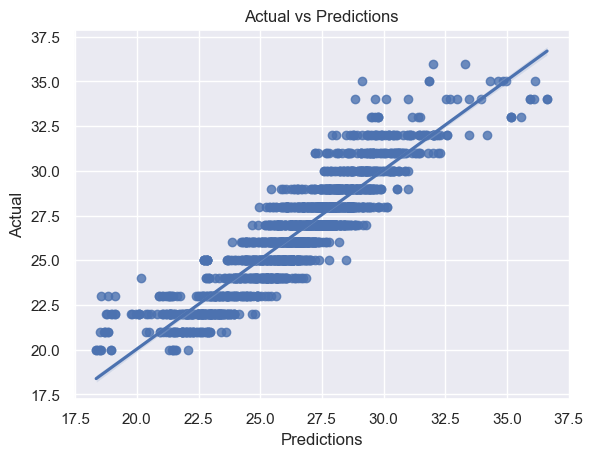

In [48]:
# plt.scatter(x=y_pred, y=y_test);
sns.regplot(x=y_pred, y=y_test);
plt.title(label="Actual vs Predictions");
plt.xlabel(xlabel="Predictions");
plt.ylabel(ylabel="Actual");

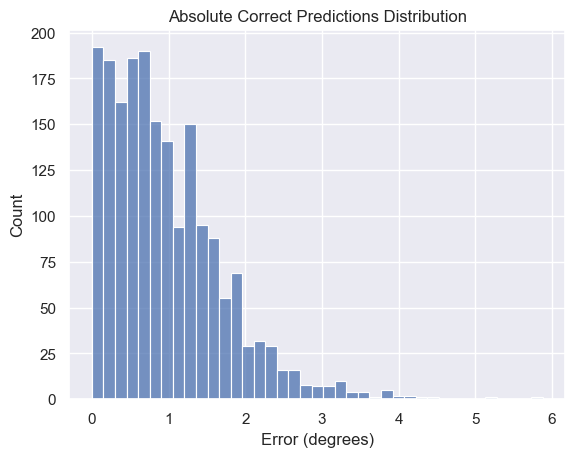

In [49]:
sns.histplot(abs(y_test-y_pred));
plt.title("Absolute Correct Predictions Distribution")
plt.xlabel(xlabel="Error (degrees)");
plt.ylabel(ylabel="Count");

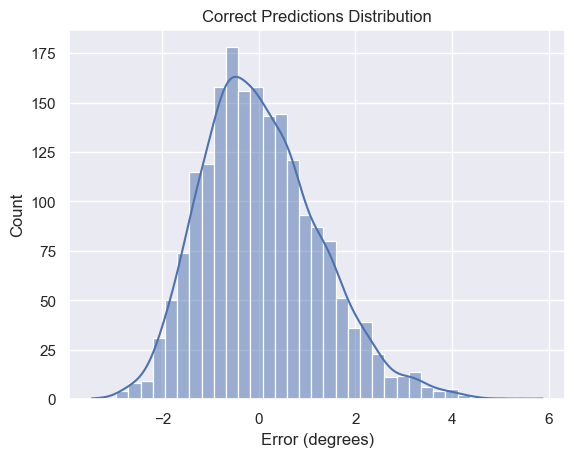

In [50]:
sns.histplot(y_test-y_pred, kde=True);
plt.title("Correct Predictions Distribution")
plt.xlabel(xlabel="Error (degrees)");
plt.ylabel(ylabel="Count");

In [51]:
len(df_combined_data)

5804

In [52]:
Adj_r2 = 1-(1-r2_score(y_test, y_pred))*(len(df_combined_data)-1)/(len(df_combined_data)-X_test.shape[1]-1)

print("MAE:", metrics.mean_absolute_error(y_test, y_pred))
print("MSE:", metrics.mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("r2 score:", r2_score(y_test, y_pred))
print("Adjusted r2 score:", Adj_r2)


MAE: 0.9654028168746035
MSE: 1.4915699807599438
RMSE: 1.221298481436845
r2 score: 0.8265563460928159
Adjusted r2 score: 0.8264367091527178


### Ridge regression

In [53]:
# creating ridge object
ridge = Ridge()

In [54]:
# fitting ridge object to training data
ridge.fit(X_train,y_train)

Ridge()

In [55]:
# putting predictions into pred object
y_pred = ridge.predict(X_test)

In [56]:
Adj_r2 = 1-(1-r2_score(y_test, y_pred))*(len(df_combined_data)-1)/(len(df_combined_data)-X_test.shape[1]-1)

print("MAE:", metrics.mean_absolute_error(y_test, y_pred))
print("MSE:", metrics.mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("r2 score:", r2_score(y_test, y_pred))
print("Adjusted r2 score:", Adj_r2)


MAE: 0.9654031805417478
MSE: 1.4916084664897948
RMSE: 1.2213142374056707
r2 score: 0.8265518708716096
Adjusted r2 score: 0.8264322308446199
